Notebook to calculate the continuum subtraction for the narrow-band HST imagery of the Sunburst Arc.  Uses Prospector (from Gourav) to calculate the SED, separate out the continuum part, and then use Pysynphot to determine how to use the off-band filters to continuum subtract the narrow bands that contain the emission lines.  Using the pysynphot tutorials to get started.  jrigby, July 2021

The list of emission lines and filters is in this beginnings of a google doc: https://docs.google.com/document/d/1G9U1kWM4SVMKJN7Tv1H0L_Pbrow4jhzkxCjx4SqyxCM/edit

We have 4 different narrow-bands:  Lya, [O II], Hbeta, and [O III].  Here they are, with continua:
- F410M   Lya.
- F390W   Lya continuum
- F555W   UV continuum.  Also continuum for Lya
- F126N    [O II] 3727/3729
- F128N   continuum for [O II]
- F153M   continuum for H beta and [O III].  (May have small contam from He II 4687)
- F164N   Hbeta.
- F167N    [O III]

In [1]:
import matplotlib.pyplot as plt
import pysynphot as S
import os
import glob
import numpy as np
from astropy.io import fits

In [2]:
# Example from the pysynphot tutorials: Vega
vega_file = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'alpha_lyr_stis_005.fits')
vega = S.FileSpectrum(vega_file)
vega.convert('flam')

In [3]:
arcfile = "Example_data/gourav_SED.txt"
gouravfits = [ x for x in glob.glob('Example_data/' + "bestfit_model*.txt") ]
# format is numpy: 2 Rows, observed wavelength (A) and flux density in maggies (Jansky/3631)
arcspec = []
for ii, gouravfit in enumerate(gouravfits) :
    wave,flux_maggies =  np.loadtxt(gouravfit)
    fnu_Jy = flux_maggies *3631.
    arcspec.append(S.ArraySpectrum(wave=wave, flux=fnu_Jy, waveunits='Angstroms', fluxunits='Jy'))

Text(0, 0.5, 'jy')

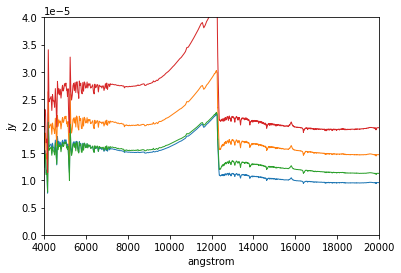

In [4]:
for thisspec in arcspec :
    plt.plot(thisspec.wave, thisspec.flux)
plt.xlim(4000, 2E4)
plt.ylim(0, 0.4E-4)
plt.xlabel(arcspec[0].waveunits)
plt.ylabel(arcspec[0].fluxunits)

- Filter 1 has line and continuum emission.
- Filter 2 just has continuum emission.
- How to use Filter 2 to continuum subtract filter 1?
- line emission = continuum_f1 + emissline_f1 - continuum_f2 * scaling_factor
- scaling_factor = countrate_f1 / countrate_f2

In [5]:
debug = False
setups = ('wfc3,uvis1,f410m', 'wfc3,uvis1,f390w', 'wfc3,uvis1,f555w', 'wfc3,ir,f126n', 'wfc3,ir,f128n', 'wfc3,ir,f153m', 'wfc3,ir,f164n', 'wfc3,ir,f167n')
scaleF390W_for_Lya   = np.empty(len(arcspec))  # Scale factor for continuum filter, before subtracting from filter w emiss line
scaleF555W_for_Lya   = np.empty(len(arcspec))  # Try F555W as cont filter instead of F390W
scaleF128N_for_OII   = np.empty(len(arcspec))
scaleF153M_for_Hbeta = np.empty(len(arcspec))
scaleF153M_for_OIII  = np.empty(len(arcspec))
contF410M     = np.empty(len(arcspec))   # Calculated continuum in the filter containing the emission line
contF410M_alt = np.empty(len(arcspec))   # Try F555W as cont filter instead of F390W
contF126N = np.empty(len(arcspec))
contF164N = np.empty(len(arcspec))
contF167N = np.empty(len(arcspec))

In [6]:
# Calculate count-rate in each filter, for the injected continuum-only spectrum.  Keren says don't forget (1+z)
for ii, thisspec in enumerate(arcspec) :
    print(ii, gouravfits[ii])
    countrate = {}
    for setup in setups :
        obs = S.Observation(thisspec, S.ObsBandpass(setup))
        countrate[setup] = obs.countrate()
        if debug : print(setup, np.round(countrate[setup], decimals=3))
           
    scaleF390W_for_Lya[ii] = countrate['wfc3,uvis1,f410m'] / countrate['wfc3,uvis1,f390w']  # continuum for Lya
    contF410M[ii] = scaleF390W_for_Lya[ii] * countrate['wfc3,uvis1,f390w']
    print(scaleF390W_for_Lya[ii], contF410M[ii], "scale_factor, countrate in continuum, for Lya")
    #
    scaleF555W_for_Lya[ii] = countrate['wfc3,uvis1,f410m'] / countrate['wfc3,uvis1,f555w']  # alt continuum for Lya
    contF410M_alt[ii] = scaleF555W_for_Lya[ii] * countrate['wfc3,uvis1,f555w']
    print(scaleF555W_for_Lya[ii], contF410M_alt[ii], "scale_factor, countrate in continuum, for Lya")
    #
    scaleF128N_for_OII[ii] = countrate['wfc3,ir,f126n'] / countrate['wfc3,ir,f128n']   # Continuum for OII3727
    contF126N[ii] = scaleF128N_for_OII[ii] * countrate['wfc3,ir,f128n']
    print(scaleF128N_for_OII[ii], contF126N[ii], "scale_factor, countrate in continuum, for [O II] 3727,3729")
    #
    scaleF153M_for_Hbeta[ii] = countrate['wfc3,ir,f164n'] / countrate['wfc3,ir,f153m']  # continuum for Hbeta
    contF164N[ii] = scaleF153M_for_Hbeta[ii] * countrate['wfc3,ir,f153m']
    print(scaleF153M_for_Hbeta[ii], contF164N[ii], "scale_factor, countrate in continuum, for Hbeta")
    #
    scaleF153M_for_OIII[ii] = countrate['wfc3,ir,f167n'] / countrate['wfc3,ir,f153m']  # continuum for 5007
    contF167N[ii] = scaleF153M_for_OIII[ii] * countrate['wfc3,ir,f153m']
    print(scaleF153M_for_OIII[ii], contF167N[ii], "scale_factor, countrate in continuum, for [O III] 5007")
    print("----------------")

0 Example_data/bestfit_model_image4_spec_filter6_cont.txt
0.18103125362542904 10.09331404145855 scale_factor, countrate in continuum, for Lya
0.1060113362913691 10.09331404145855 scale_factor, countrate in continuum, for Lya
0.8999332495517403 4.235774415831871 scale_factor, countrate in continuum, for [O II] 3727,3729
0.22912404161818037 3.886697023300045 scale_factor, countrate in continuum, for Hbeta
0.24100356983598167 4.08821287749085 scale_factor, countrate in continuum, for [O III] 5007
----------------
1 Example_data/bestfit_model_image2_spec_filter6_cont.txt
0.1841702935473978 12.296530649529963 scale_factor, countrate in continuum, for Lya
0.10334270218073707 12.296530649529963 scale_factor, countrate in continuum, for Lya
0.8857264998009174 6.400638773449031 scale_factor, countrate in continuum, for [O II] 3727,3729
0.22779502663331783 6.023313972770967 scale_factor, countrate in continuum, for Hbeta
0.2404781943574707 6.358679948494662 scale_factor, countrate in continuum, 

In [26]:
outdir  = "/Users/jrrigby1/SCIENCE/Lensed-LBGs/Planck_Arc/JR_narrowband/"
work_on_convolved = True  ## MAKE A CHOICE

if work_on_convolved :
    fitsdir = "/Users/jrrigby1/SCIENCE/Lensed-LBGs/Planck_Arc/Sunburst_HST_Version4.0/Convolved_to_F160W/"
    prefix= "V4.0_PSZ1G311.65-18.48_"  ; suffix = "_sci_convolved_to_F160W.fits.gz"
    #          F390W, F555W  F128N, F153, F153)  # W in the filter part of filename is Mike's typo
    offband = ("F390W_0.03g0.8_cr1.2_0.7_drc", "F555W_0.03g0.8_cr1.2_0.7_drc", "F128W_0.03g0.8_cr4.0_0.7_drz", "F153W_0.03g0.8_cr4.0_0.7_drz", "F153W_0.03g0.8_cr4.0_0.7_drz")
    #       F410M   F410M  F126N  F164N   F167N
    onband  = ("F410M_0.03g0.8_cr1.2_0.7_drc", "F410M_0.03g0.8_cr1.2_0.7_drc", "F126W_0.03g0.8_cr4.0_0.7_drz", "F164W_0.03g0.8_cr4.0_0.7_drz", "F167W_0.03g0.8_cr4.0_0.7_drz")
    outfilename = ("Lya_contsubF390W_convolved", "Lya_contsubF555W_convolved", "OII_contsub_convolved", "Hbeta_contsub_convolved", "OIII_contsub_convolved")

else :
    fitsdir = "/Users/jrrigby1/SCIENCE/Lensed-LBGs/Planck_Arc/Sunburst_HST_Version4.0/"
    prefix= "V4.0_PSZ1G311.65-18.48_"  ; suffix = "_sci.fits.gz"
    #          F390W, F555W  F128N, F153, F153)  # W in the filter part of filename is Mike's typo
    offband = ("F390W_0.03g0.8_cr1.2_0.7_drc", "F555W_0.03g0.8_cr1.2_0.7_drc", "F128W_0.03g0.8_cr4.0_0.7_drz", "F153W_0.03g0.8_cr4.0_0.7_drz", "F153W_0.03g0.8_cr4.0_0.7_drz")
    #       F410M   F410M  F126N  F164N   F167N
    onband  = ("F410M_0.03g0.8_cr1.2_0.7_drc", "F410M_0.03g0.8_cr1.2_0.7_drc", "F126W_0.03g0.8_cr4.0_0.7_drz", "F164W_0.03g0.8_cr4.0_0.7_drz", "F167W_0.03g0.8_cr4.0_0.7_drz")
    outfilename = ("Lya_contsubF390W", "Lya_contsubF555W", "OII_contsub", "Hbeta_contsub", "OIII_contsub")    

In [27]:
print("Reporting above results more cleanly")
scalefactors = (scaleF390W_for_Lya, scaleF555W_for_Lya, scaleF128N_for_OII, scaleF153M_for_Hbeta, scaleF153M_for_OIII)
theconts     = (contF410M, contF410M_alt, contF126N, contF164N, contF167N)
for ii, scalefactor in enumerate(scalefactors):
    print("group", ii, "scaleby", np.round(scalefactor, 3), np.round(scalefactor.mean(), 3), "+/-", np.round(np.std(scalefactor), 3), ': ', end='')
    print("cont countrate: ", np.round(theconts[ii].mean(), 3), "+/-", np.round(np.std(theconts[ii]), 3))
    #print(onband[ii], offband[ii])
    offbandfile = prefix + offband[ii] + suffix
    onbandfile  = prefix + onband[ii]  + suffix
    data_off, header_off = fits.getdata(fitsdir + offbandfile, header=True)
    data_on, header_on   = fits.getdata(fitsdir + onbandfile,  header=True)
    data_contsub = data_on - data_off * scalefactor.mean()
    contmath = onband[ii] + " - " + offband[ii] + " * " + str(np.round(scalefactor.mean(), 8))
    # Now, make a new image, and update the header
    header_on['CONTSUBT'] = (np.round(scalefactor.mean(), 8), 'jrigby continuum subtraction')
    header_on['CONTMATH'] = contmath
    fits.writeto(outdir+outfilename[ii]+'.fits', data_contsub, header_on, overwrite=True) 
    #print(onbandfile, offbandfile, '../JR_narrowband/' + outfilename[ii]+'.fits')

Reporting above results more cleanly
group 0 scaleby [0.181 0.184 0.184 0.184] 0.183 +/- 0.001 : cont countrate:  11.801 +/- 2.119
group 1 scaleby [0.106 0.103 0.105 0.098] 0.103 +/- 0.003 : cont countrate:  11.801 +/- 2.119
group 2 scaleby [0.9   0.886 0.884 0.899] 0.892 +/- 0.007 : cont countrate:  5.935 +/- 1.495
group 3 scaleby [0.229 0.228 0.227 0.231] 0.229 +/- 0.002 : cont countrate:  5.58 +/- 1.47
group 4 scaleby [0.241 0.24  0.24  0.244] 0.241 +/- 0.001 : cont countrate:  5.883 +/- 1.55


Great!  The scaling factors I've just calculated, when applied to the continuum filter, do indeed remove the continuum from the filter w the emission line. This seems to be working well!  Next steps: 
- repeat the continuum subtraction, for the convolved-to-F160W images that Michael made
- DONE compute contsub for F555W as well
- DONE write up the comparison to Hakon's cont-sub

In [28]:
# compare my scale factors to Hakons
Hakon = [99, 0.0825, 0.925, 0.267, 0.293]  # First 2 are 99 b/c Hakon didn't send me his Lya scaling yet. 
# see #psz1g311 thread on slack, July 22 2021
for ii, scalefactor in enumerate(scalefactors):
    print( (Hakon[ii] - scalefactor.mean()) / scalefactor.mean())

539.3349816197754
-0.19900055760700888
0.03683226429746191
0.16654350801783555
0.21420440133489804
